# Performance analysis on synthetic data generators

This notebooks applies multiple synthetic data generator to simulate the real data set, Complete Journey. We provide step-by-step instructions on how to use each generator and analyze their performance from perspectives of Fidelity, Utility, and Privacy.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_regression import LinearRegression

from syncomp.metrics.fidelity import (
    gather_fidelity_info_from_df,
    compare_fidelity_info
)
from syncomp.metrics.utility import (
    get_regression_training_data,
    train_eval_regression_model
)
from syncomp.utils.viz_util import plot_heatmap, plot_hist

%reload_ext autoreload
%autoreload 2

## Real Data Exploration

> The Complete Journey dataset characterizes household level transactions over one year from a group of 2,469 households who are frequent shoppers at a grocery store. It contains all of each household’s purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are captured.

For a deep dive into the dataset exploration and data cleaning, please refer to notebook [Complete Journey Data Exploration](https://github.com/RetailMarketingAI/retailsynth/blob/main/analysis_workflow/1_complete_journey_eda/1_preprocess_analysis.ipynb).

In [2]:
# TODO: Show distributions of some key categorical variables and numerical variables we're gonna use to evaluate the model.

In [63]:
# read real df and synthetic df
real_df = pd.read_parquet('../results/complete_dataset_filtered.parquet')

## Models
1. StaSy
2. TabDDPM
3. AutoGAN
4. StaSy-AutoDiff
5. Med-AutoDiff
6. Tab-AutoDiff
7. CTGAN: https://github.com/sdv-dev/CTGAN
8. CTAB-GAN: https://github.com/Team-TUD/CTAB-GAN
7. RetailSynth[Optional]: Notice that RetailSynth focuses on imitating the transaction only, that it does not necessarily synthesize the categorical features, like customer demographics.

In [3]:
# TODO: need to finalize the list of models with Chi-Hua
# TODO: add shell command to run training jobs

## Metrics

### Fidelity
1. Wasserstein distance of probability distributions for the following numerical features:
    - Store visit probability
    - Product purchase probability
    - Product demand
    - Basket size
    - Time between purchase
    - Price elasticity
2. Jensen Shannon divergence of distributions for the following categorical features:
    - Customer demographics (age, household size, etc.)
    - Store information (state, city, etc.)
3. Pearson Correlation between listed numerical features
4. Theil's U for listed categorical features
5. Correlation Ratio between listed categorical and numerical features
6. Business insights
    - Customer segmentation
    - Customer retention
    - Category penetration

In [64]:
# read synthetic df
syn_df = pd.read_csv('../results/synthetic_data/AutoDiff/complete_dataset_filtered/AutoDiff_complete_dataset_filtered1.csv')

categorical_columns = real_df.select_dtypes(include=['object']).columns
syn_df[categorical_columns] = syn_df[categorical_columns].astype(str)

In [65]:
sample_size = 1000
real_fidelity_info = gather_fidelity_info_from_df(real_df, sample_size=sample_size, exclude_columns=['household_id', 'basket_id'])
syn_fidelity_info = gather_fidelity_info_from_df(syn_df, sample_size=sample_size, exclude_columns=['household_id', 'basket_id'])

/Users/64313/Documents/repos/syncomp/syncomp/metrics/corr.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_values, inplace=True)
/Users/64313/Documents/repos/syncomp/syncomp/metrics/corr.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

(0.0, 30.0)

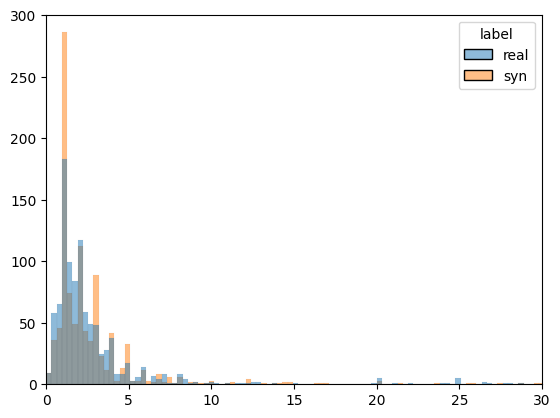

In [118]:
ax = plot_hist(real_fidelity_info[0]["revenue"], syn_fidelity_info[0]["revenue"])
ax.set_xlim(0, 30)

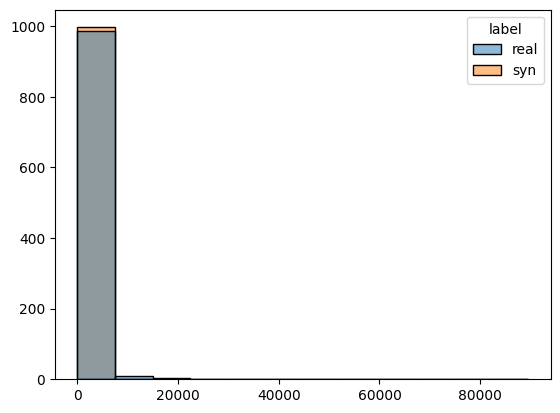

In [125]:
ax = plot_hist(real_fidelity_info[0]["quantity"], syn_fidelity_info[0]["quantity"])
# there are some products from the fuel department that have extremely large demand, because its measurement unit is small

In [87]:
fidelity_metrics = compare_fidelity_info(real_fidelity_info, syn_fidelity_info)

In [88]:
# show the wasserstein distance between numerical features from the real and synthetic data
fidelity_metrics[0]

{'visit_prob_per_store': 0.046418216783424594,
 'purchase_prob_per_product': 0.6209563166617739,
 'basket_size_per_product': 2897155.4449224626,
 'time_between_purchase_per_customer': 9.110425652850381,
 'customer_retention_per_store': 0.11453231307884262,
 'category_penetration_per_category': 0.06881961598947244,
 'unit_price': 0.22629192959542838,
 'base_price': 0.4586368971917018,
 'revenue': 0.9499540405440338,
 'quantity': 259.9182792968752}

In [89]:
# show the jensenshannon distance between categorical features from the real and synthetic data
fidelity_metrics[1]

{'age': 0.26976754570654826,
 'income': 0.27491759006904964,
 'household_size': 0.2523223451817035,
 'kids_count': 0.2975381860490951,
 'product_category': 0.33347471736742185,
 'department': 0.194456474000411}

In [90]:
# show the euclideand distance between the correlation matrix of the real and synthetic data
fidelity_metrics[2]

{'pearson_coef': 2.427069111513428,
 'theils_u': 4.455302907152082,
 'correl_ratio': 2.6141092948491993}

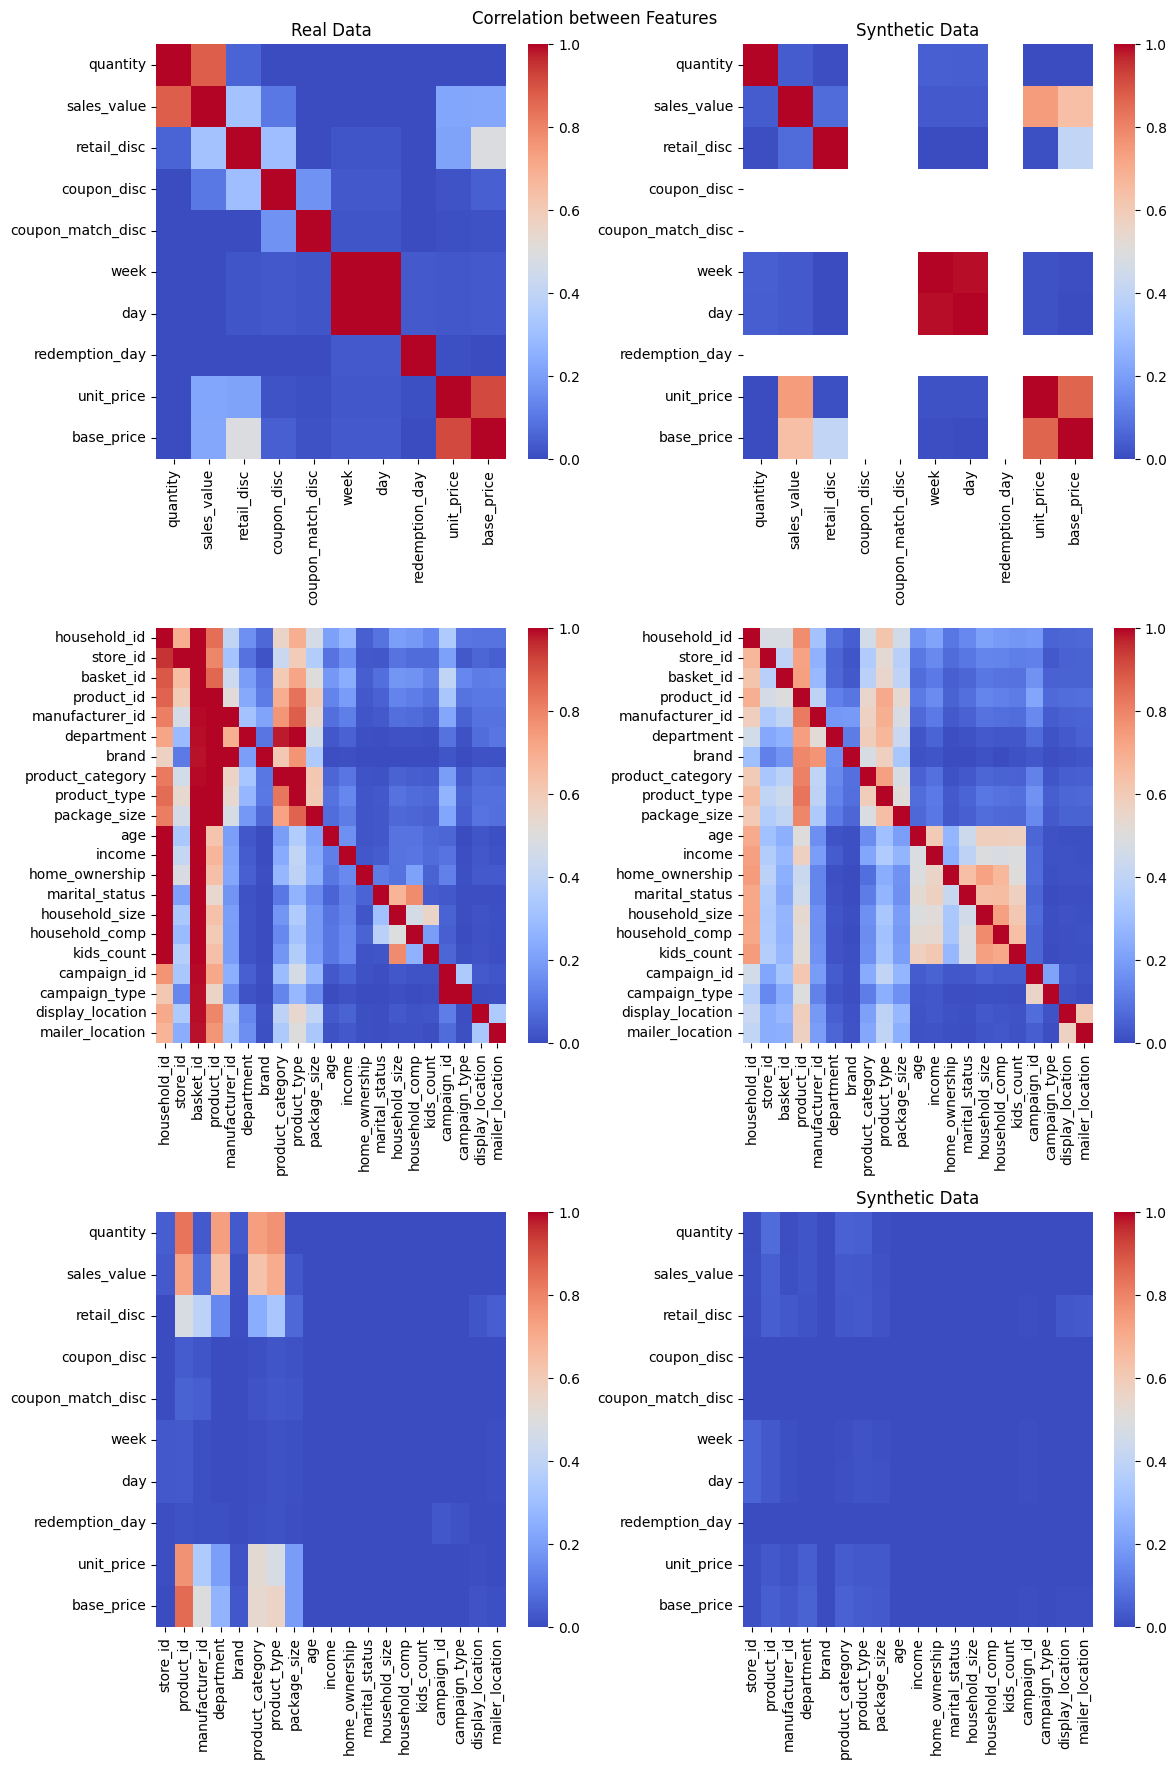

In [69]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
ax1, ax2 = axes[0]
plot_heatmap(real_fidelity_info[2]['pearson_coef'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info[2]['pearson_coef'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)
ax1.set_title('Real Data')
ax2.set_title('Synthetic Data')
ax1, ax2 = axes[1]
plot_heatmap(real_fidelity_info[2]['theils_u'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info[2]['theils_u'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)
ax1, ax2 = axes[2]
plot_heatmap(real_fidelity_info[2]['correl_ratio'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info[2]['correl_ratio'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)

plt.suptitle('Correlation between Features')
plt.tight_layout()

### Utility
We define a classification task and a regression task to justify if statistical ML models can learn the patterns from the synthetic data. Classification task is to predict whether the customer will make a purchase at one time step. Regression task is to predict the total demand or revenue of a customer at one time step. 
1. Classification task
    - Accuracy
    - F1 score
    - ROC AUC
    - Precision-Recall

In [ ]:
# TODO implement the classification task

2. Regression task
    - Mean Squared Error
    - R2 score

In [146]:
real_X, real_y = get_reg_training_data(real_df)
syn_X, syn_y = get_reg_training_data(syn_df)
# train a linear regression model
real_metric = train_eval_regression_model(LinearRegression, real_X, real_y)
syn_metric = train_eval_regression_model(LinearRegression, syn_X, syn_y)

In [156]:
real_metric

{'mse': 66960095.34829329, 'r2': 0.7056102064047103}

In [158]:
syn_metric

{'mse': 29910319.80664679, 'r2': 0.07999820855261441}

We also define an unsupervised learning task to justify if clustering algorithms can learn the patterns from the synthetic data. The clustering task is to cluster the customers based on their purchase behavior.
1. Silhouette Score between synthetic cluster and real cluster

### Privacy
1. Distances to Closest Records
2. TAPAS: https://github.com/alan-turing-institute/tapas

In [ ]:
# TODO: find existing implementation of the following metrics potentially in the lab repo